<a href="https://colab.research.google.com/github/rnambilakshmi/Neural-Style-Transfer/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preprocessing steps

Import and configure modules

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

from PIL import Image
import time
import functools

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import backend as K

TensorFlow is already loaded. Please restart the runtime to change versions.


Enabling eager execution

In [0]:
tf.enable_eager_execution()

Eager execution: True


In [0]:
style_pic = 'picasso_selfportrait.jpg'
content_pic = 'japanese_garden.jpg'

##Visualizing input 

###load_img 

Takes the image and resizes it such that the length of the length of the longer edge is 512 and converts it into a numpy array

ANTIALIAS is a high quality downsampling filter


In [0]:
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img) # Converts a PIL Image instance to a Numpy array
 
  img = np.expand_dims(img, axis=0) # Broadcast the image array such that it has a batch dimension 
  return img

###imshow
Removes the batch dimension of dimension 1 and is projected as an unsigned int between 0 to 255

In [0]:
def imshow(img, title=None):
  out = np.squeeze(img, axis=0)
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

Showing image

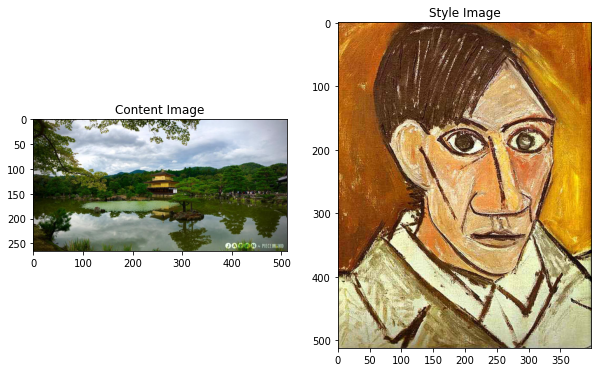

In [0]:
plt.figure(figsize=(10,10))

content = load_img(content_pic).astype('uint8')
style = load_img(style_pic).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

##Preparing the data
Preprocessing processes according to the VGG training process. The channels are BGR and are normalized by ``` mean = [103.939, 116.779, 123.68]```

In [0]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img) # image resized
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

For viewing outputs of optimization, perform the inverse preprocessing step. As optimized image may take its values anywhere between  −∞  and  ∞ , clip it to maintain the values from within the 0-255 range.

In [0]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ('OK')
  if len(x.shape) != 3:
    raise ValueError("Invalid input")
  
  #inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8') # clip to maintain the values from within the 0-255 range
  return x

Using the network architecture VGG19, a pretrained image classification network. The intermediate layers are necessary to define the representation of content and style from our images. Deeper into the model, the intermediate layers represent higher order features.

In [0]:
# Content layer where we pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

##Building the model

### get_model
To access the intermediate layers, we get the outputs and using Keras Functional API, define the model with desired output activations

Function will load VGG19 model and access intermediate layers. The model formed from these intemediate layers will then take in image input and return the outputs from the intermediate layers from the VGG model

In [0]:
def get_model():

  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False # this layer should not be trained

  # This function gets a list as input with the layer names and selects the network layer output of the given layers
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
 
  # Build model 
  return models.Model(vgg.input, model_outputs)

##Creating loss function
###Content and style distances
Content loss

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target)) # single output, distance loss

Style loss

Define the gram matrix by making the image channels first and then subsequently matrix multiplication.

In [0]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    # Scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target)


##Applying style transfer to images
Gradient descent

In [0]:
def get_feature_representations(model, content_path, style_path):

  # Load images 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
    
  # get style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

Computing loss and gradients

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights
  
  # feed initial image (init-image) through the model
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # accumulate style losses from all layers
  # equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # same as above but for content
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # computing gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

Optimization loop

In [0]:
import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 

  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # get style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  
  # optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # counter for displaying intermediate images 
  iter_count = 1
  
  # store our best result
  best_loss, best_img = float('inf'), None
  
  
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # display
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68]) # from vgg
  min_vals = -norm_means
  max_vals = 255 - norm_means   #uint8
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # using the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))              print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 

      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

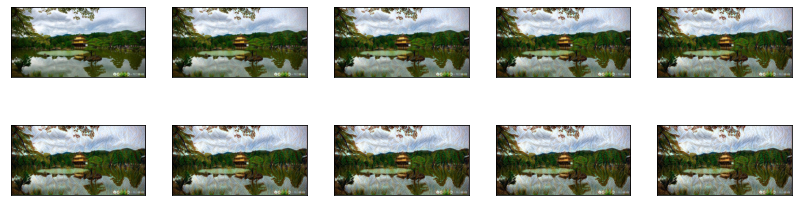

In [0]:
best, best_loss = run_style_transfer(content_pic, 
                                     style_pic, num_iterations=10)

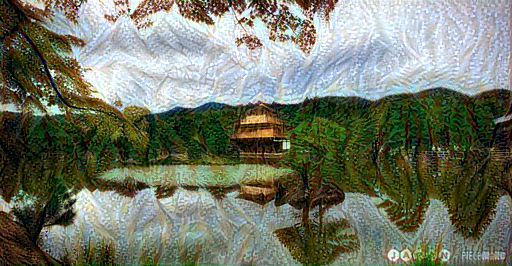

In [0]:
Image.fromarray(best)

##Visualize outputs
Deprocess the output image to remove the processing that was appiled

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

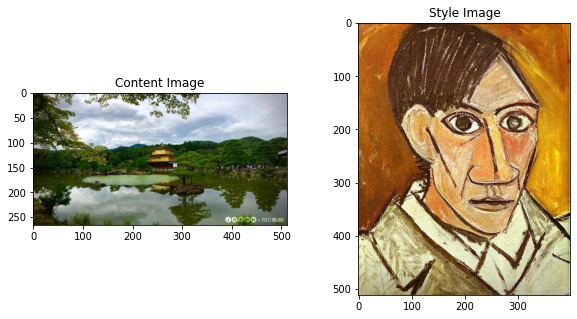

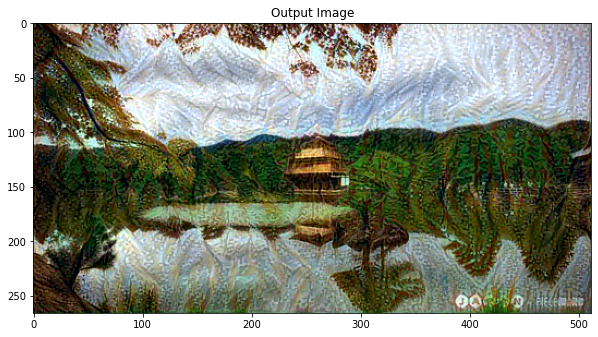

In [0]:
show_results(best, content_pic, style_pic)